<a href="https://colab.research.google.com/github/YoungJae20213137/24_Lab1_1/blob/main/IRIS_DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PyTorch version: 2.5.0+cu121
Numpy version: 1.26.4
Mean of features: [5.84333333 3.054      3.75866667 1.19866667]
Std of features: [0.82530129 0.43214658 1.75852918 0.76061262]


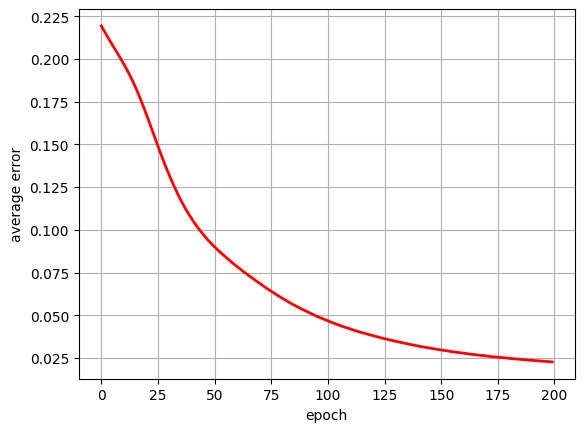

Confusion matrix:
 [[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0. 10.]]


In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

# Check Versions
print("PyTorch version: {}".format(torch.__version__))
print('Numpy version: {}'.format(np.__version__))

# Load Iris Dataset
FILE_PATH = "/MyDrive/data/"
MAIN_FILE_NAME = "iris_dataset.txt"
TRAIN_FILE_NAME = "iris_train_dataset.txt"
TEST_FILE_NAME = "iris_test_dataset.txt"
NUM_FEATURE = 4
NUM_CLASS = 3
num_epoch = 200

data = np.loadtxt("/content/drive/MyDrive/data/iris_dataset.txt", delimiter=",")
mean_data = np.mean(data[:,:NUM_FEATURE], axis=0)
std_data = np.std(data[:,:NUM_FEATURE], axis=0)

train_data = np.loadtxt("/content/drive/MyDrive/data/iris_train_dataset.txt", delimiter=",")
test_data = np.loadtxt("/content/drive/MyDrive/data/iris_test_dataset.txt", delimiter=",")

print("Mean of features: {}".format(mean_data))
print("Std of features: {}".format(std_data))

# Standardize (Pre-process) train and test data
for j in range(NUM_FEATURE):
    for i in range(train_data.shape[0]):
          train_data[i, j] = (train_data[i, j] - mean_data[j]) / std_data[j]
    for i in range(test_data.shape[0]):
          test_data[i, j] = (test_data[i, j] - mean_data[j]) / std_data[j]

# Convert scaled test and train data into PyTorch tensor
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)

# Select device to compute cpu/gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

D_in, H, D_out = NUM_FEATURE, 8, 3

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.Softmax(dim=0)
)

# MSE Loss
loss_fn = torch.nn.MSELoss(reduction='mean')

# We use Adam; the optim package contains many other optimization algorithms.
# The first argument to the Adam constructor tells the optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

idx = np.arange(train_data.size()[0])
avg_loss_list = list()
epoch_list = list()

for epoch in range(num_epoch):
    total_loss = 0
    np.random.shuffle(idx)
    for id in idx:
        y_pred = model(train_data[id,:NUM_FEATURE])
        y = train_data[id,NUM_FEATURE:]
        loss = loss_fn(y_pred, y)
        total_loss += loss
        # .detach().numpy()
        # Befroe the backward pass, use the optimizer object to zero all of the
        # gradients for the Tensors it will update (which are the learnable weights of the model)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()

    avg_loss = total_loss.detach().numpy()/train_data.size()[0]

    avg_loss_list.append(avg_loss)
    epoch_list.append(epoch)

# gpu를 사용할 때 추가 / item()
# epoch_list = np.array(epoch_list)
# avg_loss_list = np.array(avg_loss_list)

# Plot loss
plt.plot(epoch_list, avg_loss_list, 'r-', lw=2)
plt.xlabel("epoch")
plt.ylabel("average error")
plt.grid(True)
plt.show()

pred_class = list()
actual_class = list()
for i in range(test_data.shape[0]):
    y_pred_test = model(test_data[i,:NUM_FEATURE])
    val_pred, indices_pred = torch.max(y_pred_test, 0)
    val_actual, indices_actual = torch.max(test_data[i,NUM_FEATURE:], 0)
    pred_class.append(indices_pred)
    actual_class.append(indices_actual)

conf_mat = np.zeros((NUM_CLASS, NUM_CLASS))
for i, j in zip(pred_class, actual_class):
    conf_mat[i, j] += 1
print("Confusion matrix:\n", conf_mat)